In [ ]:
!pip install numpy torch sympy scikit-learn matplotlib


In [2]:
import numpy as np
from sympy import isprime
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Create Dataset

N = 100000
x_data = []
y_data = []
prime_count = 0

for i in range(1, N + 1):
  if isprime(i):
    prime_count+=1
  x_data.append(i)
  y_data.append(prime_count)

print("\nDataset generation complete.")
X = np.array(x_data, dtype=np.float32).reshape(-1, 1)
Y = np.array(y_data, dtype=np.float32).reshape(-1, 1)
print(X)
print(Y)


Dataset generation complete.
[[1.0000e+00]
 [2.0000e+00]
 [3.0000e+00]
 ...
 [9.9998e+04]
 [9.9999e+04]
 [1.0000e+05]]
[[0.000e+00]
 [1.000e+00]
 [2.000e+00]
 ...
 [9.592e+03]
 [9.592e+03]
 [9.592e+03]]


In [4]:
# Preprocess Dataset
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = x_scaler.fit_transform(X)
Y_scaled = y_scaler.fit_transform(Y)

# training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# converting to pytorch tensors
X_train_tensor = torch.from_numpy(X_train)
Y_train_tensor = torch.from_numpy(Y_train)
X_test_tensor = torch.from_numpy(X_test)
Y_test_tensor = torch.from_numpy(Y_test)

In [5]:
# Model
class PrimeCounter(nn.Module):
    def __init__(self):
        super(PrimeCounter, self).__init__()
        self.layer1 = nn.Linear(1, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 128)
        self.output_layer = nn.Linear(128, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.output_layer(x)
        return x

model = PrimeCounter()
print(model)

PrimeCounter(
  (layer1): Linear(in_features=1, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
)


In [6]:
# Model Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# parameters
num_epochs = 200
batch_size = 128

# dataloader
for epoch in range(num_epochs):
    model.train()

    permutation = torch.randperm(X_train_tensor.size(0))

    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], Y_train_tensor[indices]

        # forward pass
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validation check
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, Y_test_tensor)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')

Epoch [20/200], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [40/200], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [60/200], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [80/200], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [100/200], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [120/200], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [140/200], Train Loss: 0.000002, Test Loss: 0.000006
Epoch [160/200], Train Loss: 0.000001, Test Loss: 0.000000
Epoch [180/200], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [200/200], Train Loss: 0.000000, Test Loss: 0.000000


<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:21: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2092973255.py:19: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(X_true, Y_true, label='True $\pi(x)$', color='blue', linewidth=2)
/tmp/ipython-input-2092973255.py:20: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(X_true, Y_pred, label='NN Prediction $\hat{\pi}(x)$', color='red', linestyle='--', alpha=0.8)
/tmp/ipython-input-2092973255.py:21: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(X_true, Y_theorem, label='Theorem ($x / \ln(x)$)', color='green', linestyle=':', linewidth=2)


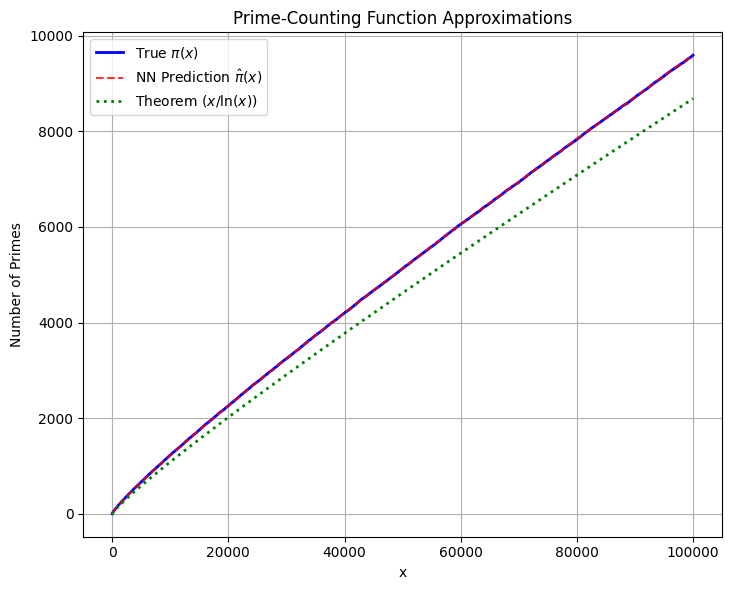

In [7]:
# Model Evaluation

model.eval()
with torch.no_grad():
    X_full_tensor = torch.from_numpy(X_scaled)
    Y_pred_scaled = model(X_full_tensor)

Y_pred = y_scaler.inverse_transform(Y_pred_scaled.numpy())
Y_true = y_scaler.inverse_transform(Y_scaled)
X_true = x_scaler.inverse_transform(X_scaled)

X_for_theorem = X_true.copy()
X_for_theorem[0] = 1.1
Y_theorem = X_for_theorem / np.log(X_for_theorem)

# plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(X_true, Y_true, label='True $\pi(x)$', color='blue', linewidth=2)
plt.plot(X_true, Y_pred, label='NN Prediction $\hat{\pi}(x)$', color='red', linestyle='--', alpha=0.8)
plt.plot(X_true, Y_theorem, label='Theorem ($x / \ln(x)$)', color='green', linestyle=':', linewidth=2)
plt.title('Prime-Counting Function Approximations')
plt.xlabel('x')
plt.ylabel('Number of Primes')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()